In [1]:
import os
import pandas as pd
import numpy as np
import glob
from pathlib import Path
import cv2
import seaborn as sns
import fastai
from fastai.vision import *
from fastai.callbacks import SaveModelCallback, EarlyStoppingCallback, ReduceLROnPlateauCallback
from tqdm.notebook import tqdm as tqdm
import json
import torch.nn.functional as F
import torch.nn as nn

with open("../user_config.json") as config:
    path_dict = json.load(config)['data_paths']
    video_path = path_dict['video_path']
    IMAGE_DIR = path_dict['large_faces']
#IMAGE_DIR = '/media/joni/DeepFake/large_faces_2/'
print("Videos: " + video_path)

Videos: /mnt/945C2D6E5C2D4BF4/Kaggle/DeepFake/data


In [2]:
from util.ImageSampling import getBalancedVideoDataFrame

**Data rules**

- 1st level 4th fold is validation
- Only one person cases
- Remove nans and videos without proper face detections
- Sample order: real1, random_fake_of_real_1, real2, random_fake_of_real_2, ...

In [3]:
df = pd.read_csv('../data/metadata_tr_val_split_folds.csv')
df = df[df['split']=='1st_level']
df = df[df['person_count']==1]
df = df[df['first_person_label']>-1]
df['isValFold'] = df['cv_fold'] == 1
df = df[df['cv_fold']<5]
df.head()

,index,label,split,isVal,cv_fold,person_count,first_person_label,second_person_label,first_person_frame_labels,second_person_frame_labels,original,version,isValFold
0,gmuagvvcen.mp4,FAKE,1st_level,False,3,1,3.0,NaN,"[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, ...",NaN,xyioxposka.mp4,2020-02-17,False
1,nlbejgudfx.mp4,FAKE,1st_level,False,1,1,3.0,NaN,"[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, ...",NaN,acguxjvmju.mp4,2020-02-17,True
2,smptxlklxc.mp4,REAL,1st_level,False,0,1,0.0,NaN,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",NaN,NaN,2020-02-17,False
3,xmodyeeaxr.mp4,FAKE,1st_level,False,1,1,1.0,NaN,"[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, ...",NaN,ptpwappdyx.mp4,2020-02-17,True
5,duhilxsfwa.mp4,FAKE,1st_level,False,2,1,3.0,NaN,"[3, 2, 3, 2, 3, 2, 2, 2, 3, 3, 3, 3, 3, 3, 2, ...",NaN,pfbdxvexft.mp4,2020-02-17,False


In [4]:
df_balanced = getBalancedVideoDataFrame(df)
df_balanced.head()

,path,label,isValFold
0,vufoucpoxb.mp4,0,False
1,tjisgyfzrm.mp4,3,False
2,qqhrtjjcgr.mp4,0,False
3,sooepnutvq.mp4,4,False
4,ioqacgyrwh.mp4,0,True


In [5]:
len(df_balanced)

26310

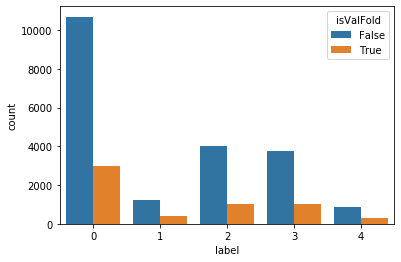

In [6]:
sns.countplot(x='label',hue='isValFold',data=df_balanced)

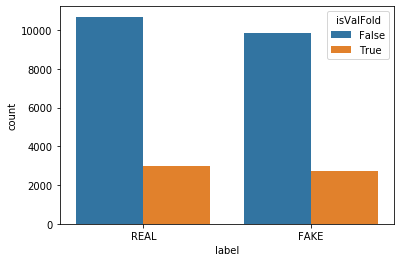

In [7]:
df_balanced['label'] = np.where(df_balanced['label'] > 0, 'FAKE', 'REAL')
sns.countplot(x='label',hue='isValFold',data=df_balanced)

In [8]:
df_balanced['path'] = [s.replace('.mp4','') for s in df_balanced['path'].values]
df_balanced.head()

,path,label,isValFold
0,vufoucpoxb,REAL,False
1,tjisgyfzrm,FAKE,False
2,qqhrtjjcgr,REAL,False
3,sooepnutvq,FAKE,False
4,ioqacgyrwh,REAL,True


## Multiframe dataloader

In [35]:
sys.path.append('../detector/')
from RecurrentModel.RecurrentCNN import VideoSequenceModel,LightVideoSequenceModel
from RecurrentModel.RecurrentModelConfig import RecurrentModelConfig
from RecurrentModel.ImageSequence import ImageSequence
from RecurrentModel.ImageSequenceList import ImageSequenceList, ImageSequenceListOfTwo 

In [36]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [37]:
recurrent_config = RecurrentModelConfig(len_sequence=2,
                                        min_frame_index=10,
                                        max_frame_index=16)

RecurrrentModelConfig: len_sequence 2, min_frame_index 10, max_frame_index 16


In [38]:
from util.fastaiAugmentations import JPEGAugment, HueSaturationValueAugment

In [42]:
tfms = get_transforms(max_zoom=1.4,#1.0, 
                      max_rotate=10,#0, 
                      max_warp=0.0,#0,
                      max_lighting=0.4,
                      xtra_tfms=[JPEGAugment(p=0.7),HueSaturationValueAugment(p=0.2)])

videoSequenceBunch = (ImageSequenceListOfTwo.from_df(path=IMAGE_DIR,
                                                df=df_balanced)
                    .split_from_df('isValFold')
                    #How to split in train/valid? CV index
                    .label_from_df(cols='label')
                    #Where are the labels?
                    .transform(tfms)
                    # We have our custom transformations implemented in the image loader but we could apply transformations also here
                    # Even though we don't apply transformations here, we set two empty lists to tfms. Train and Validation augmentations
                    .databunch(bs=1))

# don't shuffle to keep the ordered real-fake pairs in the same batches
videoSequenceBunch.train_dl = videoSequenceBunch.train_dl.new(shuffle=False)

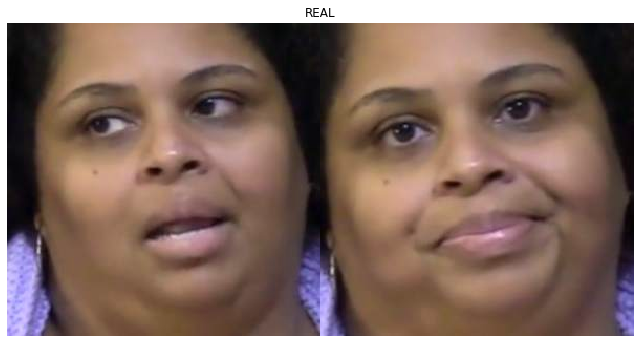

In [43]:
videoSequenceBunch.show_batch()

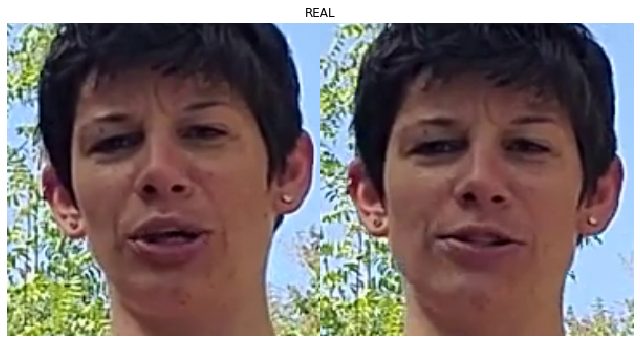

In [44]:
videoSequenceBunch.show_batch(ds_type=DatasetType.Valid)

In [45]:
from fastai import *
from fastai.vision import *
from fastai.callbacks import *
from fastai.vision import learner

from util.PretrainedModels import se_resnext50_32x4d

# Train

In [52]:
model = LightVideoSequenceModel(se_resnext50_32x4d()).cuda()

### Pretrained CNN backbone

Apply initialization

In [53]:
apply_init(model.lstm1, nn.init.kaiming_normal_)
apply_init(model.linear1, nn.init.kaiming_normal_)
#apply_init(model.linear2, nn.init.kaiming_normal_)

Copy weights from weights trained by self-supervision. 

In [54]:
model.body.load_state_dict(torch.load('./contrastive_trained_seresnex50_f1_20200313.pth'), strict=False)

<All keys matched successfully>

In [55]:
from fastai.layers import LabelSmoothingCrossEntropy

learn = Learner(videoSequenceBunch,
                model,
                metrics=[accuracy, error_rate],
                #layer_groups=[model.body,
                #              model.lstm1,
                #              model.linear1,model.linear2],
                loss_func=nn.CrossEntropyLoss())#LabelSmoothingCrossEntropy())#.mixup()

In [60]:
# Freeze the pretrained part at first
learn.unfreeze()

#for param in learn.model.body.parameters():
#    param.requires_grad = False

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


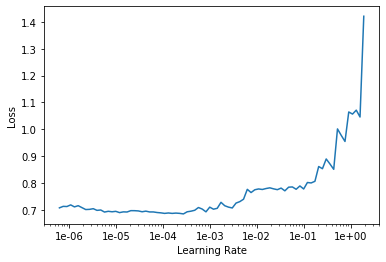

In [61]:
#learn.lr_find()
learn.lr_find()#(num_it=200)
learn.recorder.plot()

In [58]:
#from fastai.callbacks.misc import StopAfterNBatches

In [24]:
#stop_after = StopAfterNBatches(n_batches=2000)
#showGraph = ShowGraph(learn)

#learn.fit(1, 2e-5, callbacks=[stop_after, showGraph])

In [ ]:
n_epochs = 4
#lrs = [1e-5,4e-4,4e-4,1e-3] # use different lr for different layer groups
lr = 1e-4

save_cb = SaveModelCallback(learn,
                            every='improvement', 
                            monitor='accuracy',#'valid_loss', 
                            name='best')
showGraph = ShowGraph(learn)

learn.fit_one_cycle(n_epochs, lr, callbacks=[save_cb, showGraph])

epoch,train_loss,valid_loss,accuracy,error_rate,time


# Export the model

In [26]:
# load best
#learn.load('best')

In [24]:
if not os.path.exists('../models/lstm'):
    os.mkdir('../models/lstm')
os.mkdir('../models/lstm/2020_03_10-2')

In [25]:
learn.export(file="/mnt/945C2D6E5C2D4BF4/Kaggle/deepfake-video-detection/models/lstm/2020_03_10-2/export.pkl")

In [26]:
recurrent_config.toDir("/mnt/945C2D6E5C2D4BF4/Kaggle/deepfake-video-detection/models/lstm/2020_03_10-2/")